In [44]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Ejercicios

1. Cargad el csv que obtuvimos en los ejercicios de la clase invertida de ayer. 


In [45]:
df = pd.read_csv('rating_performance_insight_map_replace.csv', index_col=0)

2. ¿Qué columnas tienen nulos? 


In [46]:
columnas_nulos = df.columns[df.isnull().any()]
columnas_nulos

# Otra manera que además recuenta los nulos 

df.isnull().sum()[df.isnull().sum() > 0]

rating_five_count            45
rating_four_count            45
rating_three_count           45
rating_two_count             45
rating_one_count             45
product_color                41
product_variation_size_id    14
origin_country               17
merchant_name                 4
merchant_info_subtitle        1
dtype: int64

3. Explorad los nulos que hay en el DataFrame. 


In [47]:
cc_categoricas_nulas = df[columnas_nulos].select_dtypes(include = "O").columns
cc_numericas_nulas = df[columnas_nulos].select_dtypes(include = np.number).columns

print(f"Las columnas categóricas nulas son:\n\n{cc_categoricas_nulas}\n")

print(f"\nLas columnas numéricas nulas son:\n\n{cc_numericas_nulas}\n")


Las columnas categóricas nulas son:

Index(['product_color', 'product_variation_size_id', 'origin_country',
       'merchant_name', 'merchant_info_subtitle'],
      dtype='object')


Las columnas numéricas nulas son:

Index(['rating_five_count', 'rating_four_count', 'rating_three_count',
       'rating_two_count', 'rating_one_count'],
      dtype='object')



4. Con lo aprendido en la lección de hoy gestiona los nulos de la forma que consideres más correcta. Mañana en clase discutiremos sobre los métodos elegidos. 


In [48]:
# Empezamos con las columnas categóricas.

for col in cc_categoricas_nulas:
    print(f"La distribución de las categorías para la columna {col}")
    display(round(df[col].value_counts() / df.shape[0], 2))  # display es una función utilizada para mostrar objetos de manera más legible en Jupyter Notebooks o entornos similares. 
    print("........................")


La distribución de las categorías para la columna product_color


product_color
black         0.19
white         0.16
yellow        0.07
pink          0.06
blue          0.06
              ... 
violet        0.00
blackwhite    0.00
darkgreen     0.00
rosegold      0.00
gold          0.00
Name: count, Length: 101, dtype: float64

........................
La distribución de las categorías para la columna product_variation_size_id


product_variation_size_id
S            0.41
XS           0.23
M            0.13
XXS          0.06
L            0.03
             ... 
5            0.00
1 PC - XL    0.00
H01          0.00
40 cm        0.00
SIZE S       0.00
Name: count, Length: 106, dtype: float64

........................
La distribución de las categorías para la columna origin_country


origin_country
CN    0.96
US    0.02
VE    0.00
SG    0.00
AT    0.00
GB    0.00
Name: count, dtype: float64

........................
La distribución de las categorías para la columna merchant_name


merchant_name
广州唯适唯服饰有限公司                     0.01
greatexpectationstechnology     0.01
sjhdstoer                       0.01
cenicbeauty                     0.01
sangboostore                    0.01
                                ... 
haoduoyichinamadequality        0.00
yuzk                            0.00
congxiaolong                    0.00
coaluss                         0.00
hongkonghaijietradecolimited    0.00
Name: count, Length: 957, dtype: float64

........................
La distribución de las categorías para la columna merchant_info_subtitle


merchant_info_subtitle
np.nan                                            0.18
86 % avis positifs                                0.09
85 % avis positifs                                0.08
87 % avis positifs                                0.07
88 % avis positifs                                0.07
                                                  ... 
67 % avis positifs                                0.00
92% Positive Feedback (32,318 ratings)            0.00
83% Positive Feedback (1,821 ratings)             0.00
84% Positive Feedback (399 ratings)               0.00
88% Feedback positivo (151,914 classificações)    0.00
Name: count, Length: 90, dtype: float64

........................


In [49]:
# CASO COLUMNAS CATEGÓRICAS
#
# Solo en el caso de 'origin_country' hay una categoria claramente dominante. 
# 
# En ese caso imputaremos los nulos por la moda (CN), el resto de nulos de las columnas los sustituiremos por unknown.

moda = df['origin_country'].mode()[0]
df['origin_country'] = df['origin_country'].fillna(moda)

columnas_unknown = ['product_color', 'product_variation_size_id', 
       'merchant_name', 'merchant_info_subtitle']

for col in columnas_unknown:
    df[col] = df[col].fillna('unknown')

#Compruebo que ya no hay columnas categóricas con nulos.

columnas_categoricas_nulos = df[df.columns[df.isnull().any()]].select_dtypes(include = "O").columns
columnas_categoricas_nulos


Index([], dtype='object')

In [50]:
# CASO COLUMNAS NUMÉRICAS

# lo primero que vamos a hacer es calcular la proporción de nulos que tenemos en cada una de las columnas numericas

df[cc_numericas_nulas].isnull().sum() / df.shape[0]

# No son excesivos. Menos de un 3%.


rating_five_count     0.028608
rating_four_count     0.028608
rating_three_count    0.028608
rating_two_count      0.028608
rating_one_count      0.028608
dtype: float64

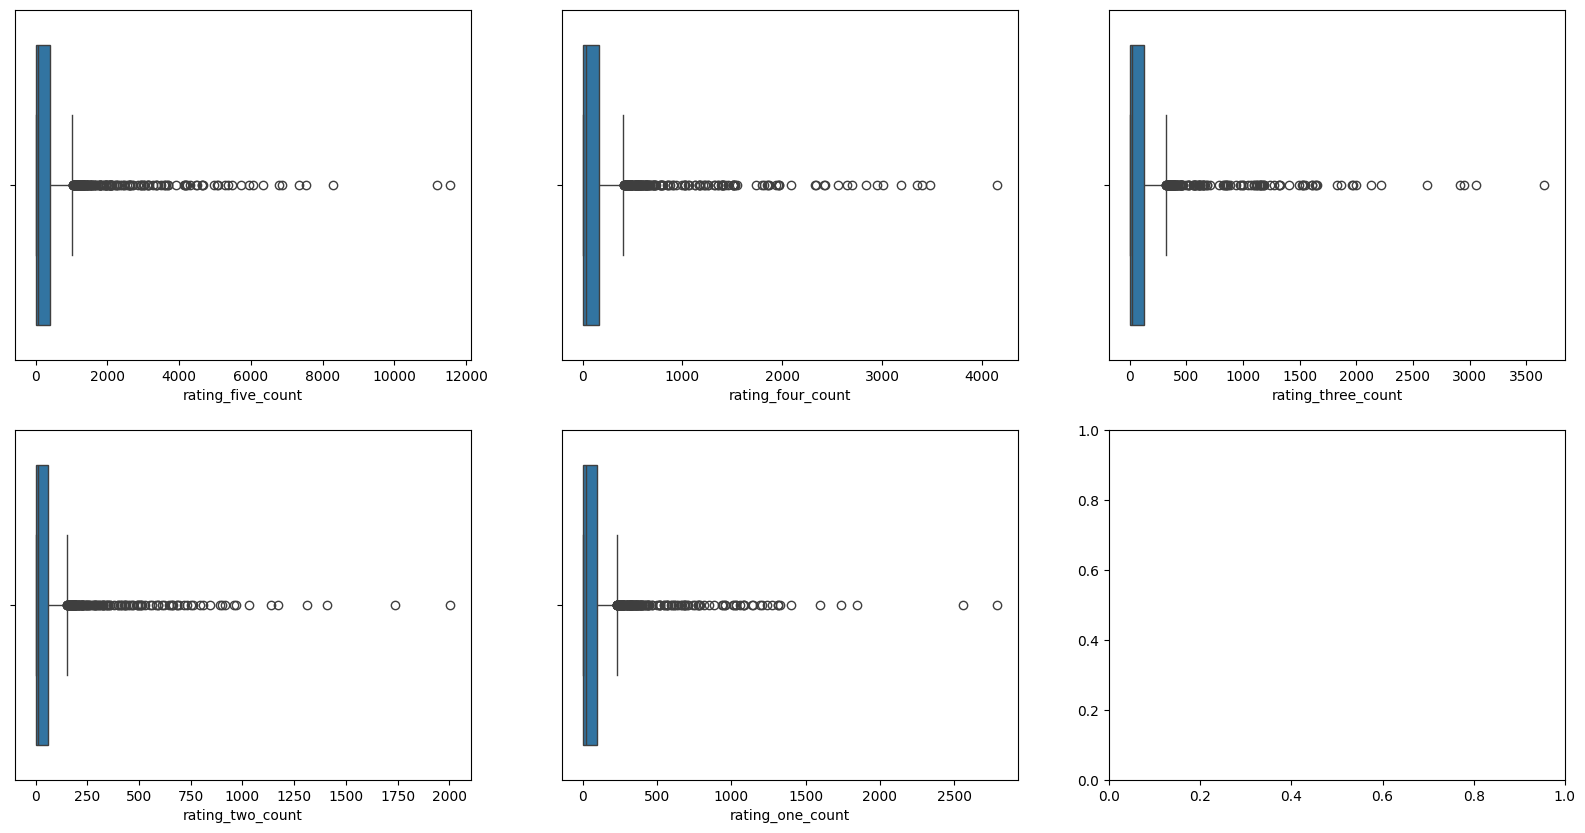

In [51]:
# Lo siguiente que tendríamos que hacer es ver si dentro de las columnas donde tenemos nulos tenemos valores atípicos. 
# Para hacer esto lo mejor es usar visualización. 

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(cc_numericas_nulas):
    sns.boxplot(x = col, data = df, ax = axes[indice])

# Vemos que hay muchos valores atípicos.


In [54]:
# como vamos a crear columnas nuevas, vamos a hacer una copia del DataFrame usando el método 'copy()'
df_copia = df.copy()

# Todas tienen valores atípicos, así que lo mejor será reemplazar los nulos con métodos avanzados como KNNImputer y IterativeImputer. 
# Después, comparamos.

# instanciamos las clases

imputer = IterativeImputer(max_iter= 20, random_state=42)

# ajustamos y tranformamos los datos

imputer_iterative_imputado = imputer.fit_transform(df[['rating_five_count', 'rating_four_count', 'rating_three_count','rating_two_count','rating_one_count']])

# comprobamos que es lo que nos devuelve, que en este caso es un array también
imputer_iterative_imputado

array([[2.600e+01, 8.000e+00, 1.000e+01, 1.000e+00, 9.000e+00],
       [2.269e+03, 1.027e+03, 1.118e+03, 6.440e+02, 1.077e+03],
       [5.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 3.000e+00],
       ...,
       [2.400e+01, 1.500e+01, 8.000e+00, 3.000e+00, 9.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]])

In [55]:
df[['rating_five_count_iter', 'rating_four_count_iter', 'rating_three_count_iter', 'rating_two_count_iter', 'rating_one_count_iter']] = imputer_iterative_imputado

In [40]:
# hagamos ahora lo mismo con el KNNImputer. NOTA, la ejecución de esta celda puede tardar un ratito

# instanciamos la clase del KNNImputer
imputer_knn = KNNImputer(n_neighbors = 5)

# ajustamos y transformamos los datos
imputer_knn_imputado = imputer_knn.fit_transform(df[['rating_five_count', 'rating_four_count', 'rating_three_count','rating_two_count','rating_one_count']])

# comprobamos que es lo que nos devuelve, que sigue siendo un array
imputer_knn_imputado

array([[2.600e+01, 8.000e+00, 1.000e+01, 1.000e+00, 9.000e+00],
       [2.269e+03, 1.027e+03, 1.118e+03, 6.440e+02, 1.077e+03],
       [5.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 3.000e+00],
       ...,
       [2.400e+01, 1.500e+01, 8.000e+00, 3.000e+00, 9.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]])

In [56]:
df[['rating_five_count_knn', 'rating_four_count_knn', 'rating_three_count_knn', 'rating_two_count_knn', 'rating_one_count_knn']] = imputer_knn_imputado

df[['rating_five_count', 'rating_five_count_knn', 'rating_five_count_iter']].describe()
#nos podemos quedar con el iterative o con el knn

,rating_five_count,rating_five_count_knn,rating_five_count_iter
count,1528.000000,1573.000000,1573.000000
mean,442.263743,442.263743,442.263743
std,980.203270,966.071776,966.071776
min,0.000000,0.000000,0.000000
25%,12.000000,13.000000,13.000000
50%,79.000000,86.000000,86.000000
75%,413.500000,442.263743,442.263743
max,11548.000000,11548.000000,11548.000000


In [57]:
df[['rating_four_count', 'rating_four_count_knn', 'rating_four_count_iter' ]].describe()
# nos podemos quedar con el iterative o con el knn

,rating_four_count,rating_four_count_knn,rating_four_count_iter
count,1528.000000,1573.000000,1573.000000
mean,179.599476,179.599476,179.599476
std,400.516231,394.742028,394.742028
min,0.000000,0.000000,0.000000
25%,5.000000,5.000000,5.000000
50%,31.500000,35.000000,35.000000
75%,168.250000,179.599476,179.599476
max,4152.000000,4152.000000,4152.000000


In [58]:
df[['rating_three_count', 'rating_three_count_knn', 'rating_three_count_iter' ]].describe()
# nos podemos quedar con el iterative o con el knn

,rating_three_count,rating_three_count_knn,rating_three_count_iter
count,1528.000000,1573.000000,1573.000000
mean,134.549738,134.549738,134.549738
std,311.690656,307.197043,307.197043
min,0.000000,0.000000,0.000000
25%,4.000000,4.000000,4.000000
50%,24.000000,26.000000,26.000000
75%,129.250000,134.549738,134.549738
max,3658.000000,3658.000000,3658.000000


In [59]:
df[['rating_two_count', 'rating_two_count_knn', 'rating_two_count_iter' ]].describe()
# nos podemos quedar con el iterative o con el knn

,rating_two_count,rating_two_count_knn,rating_two_count_iter
count,1528.000000,1573.000000,1573.000000
mean,63.711387,63.711387,63.711387
std,151.343933,149.162023,149.162023
min,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000
50%,11.000000,12.000000,12.000000
75%,62.000000,63.711387,63.711387
max,2003.000000,2003.000000,2003.000000


In [60]:
df.drop(['rating_five_count', 'rating_five_count_iter', 'rating_four_count', 'rating_four_count_knn', 'rating_three_count', 'rating_three_count_knn', 'rating_two_count', 'rating_two_count_knn', 'rating_one_count', 'rating_one_count_knn'], axis = 1, inplace = True)

In [61]:
df.columns

Index(['title', 'title_orig', 'price', 'retail_price', 'units_sold',
       'uses_ad_boosts', 'rating_x', 'rating_count', 'badge_local_product',
       'badge_product_quality', 'badge_fast_shipping', 'tags', 'product_color',
       'product_variation_size_id', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'origin_country', 'merchant_name',
       'merchant_info_subtitle', 'merchant_rating_count', 'merchant_id',
       'product_url', 'product_id', 'listed_products', 'total_units_sold',
       'mean_units_sold_per_product', 'rating_y', 'merchant_ratings_count',
       'mean_product_prices', 'mean_retail_prices',
       'mean_product_ratings_count', 'discount_percentage',
       'seller_reputation', 'rating_four_count_iter',
       'rating_three_count_iter', 'rating_two_count_iter',
       'rating_one_count_iter', 'rating_five_count_knn'],
      dtype='object')

In [62]:
nuevas_columnas = {'rating_four_count_iter': 'rating_four_count' ,
       'rating_three_count_iter': 'rating_three_count', 'rating_two_count_iter': 'rating_two_count',
       'rating_one_count_iter':   'rating_one_count' , 'rating_five_count_knn': 'rating_five_count' }

In [63]:
df.rename(columns = nuevas_columnas, inplace = True)

5. Guardad el csv para los ejercicios de la clase invertida de mañana con las columnas sin nulos. 

In [64]:
df.to_csv("merchant_fill_nonulls.csv")